In [17]:
!pip install comet-ml==3.31.17

  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.8
    Uninstalling urllib3-1.26.8:
      Successfully uninstalled urllib3-1.26.8
  Attempting uninstall: comet-ml
    Found existing installation: comet-ml 3.1.4
    Uninstalling comet-ml-3.1.4:
      Successfully uninstalled comet-ml-3.1.4


In [1]:
from comet_ml import Experiment
import configparser


In [2]:
config = configparser.ConfigParser()
config.read('./configfile.ini')
type_env = "comet_ml_prod" #comet_ml_prod
COMET_API_KEY = config[type_env]['api_key']
COMET_PROJECT_NAME = config[type_env]['project_name_xgboost']
COMET_WORKSPACE = config[type_env]['workspace']

comet_exp_obj = Experiment(api_key=COMET_API_KEY,
                           project_name=COMET_PROJECT_NAME,
                           workspace=COMET_WORKSPACE,
                           log_code=True
                          )
comet_exp_obj.set_name(name="XGBOOST MODELS")
#comet_exp_obj.log_notebook("Advanced models.ipynb")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/yasmine/xgboost-baseline/2dc504e3555f48d599fdb69301ddf843



In [44]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.dummy import DummyClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.calibration import CalibrationDisplay
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
import pickle


In [7]:
xgb.XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

# TESTING

In [8]:


pd.set_option('display.max_columns', None)
from ift6758.data.Feature_Engineering2 import tidyData, getPreviousEvent
from ift6758.data.Feature_Engineering1 import combineAllFeatures
testset = pd.read_csv('./test_set.csv')
testset

,gameID,eventType,period,periodTime,periodType,teamOfShooter,homeOrAway,xCoord,yCoord,shooter,goalie,shotType,emptyNet,strength,season,rinkSide
0,2019020001,Goal,1,00:25,REGULAR,Ottawa Senators,away,85.0,-1.0,Brady Tkachuk,Frederik Andersen,Tip-In,False,Even,2019,left
1,2019020001,Shot,1,01:31,REGULAR,Toronto Maple Leafs,home,-32.0,-2.0,Morgan Rielly,Craig Anderson,Snap Shot,NaN,NaN,2019,right
2,2019020001,Shot,1,03:23,REGULAR,Ottawa Senators,away,63.0,-6.0,Dylan DeMelo,Frederik Andersen,Snap Shot,NaN,NaN,2019,left
3,2019020001,Shot,1,03:56,REGULAR,Toronto Maple Leafs,home,-59.0,-20.0,Morgan Rielly,Craig Anderson,Wrist Shot,NaN,NaN,2019,right
4,2019020001,Shot,1,04:47,REGULAR,Toronto Maple Leafs,home,-42.0,-29.0,Tyson Barrie,Craig Anderson,Slap Shot,NaN,NaN,2019,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73467,2019030416,Shot,3,16:01,REGULAR,Tampa Bay Lightning,away,-59.0,-24.0,Anthony Cirelli,Anton Khudobin,Snap Shot,NaN,NaN,2019,left
73468,2019030416,Shot,3,17:20,REGULAR,Tampa Bay Lightning,away,-81.0,3.0,Blake Coleman,Anton Khudobin,Wrist Shot,NaN,NaN,2019,left
73469,2019030416,Shot,3,18:50,REGULAR,Dallas Stars,home,34.0,-6.0,John Klingberg,Andrei Vasilevskiy,Snap Shot,NaN,NaN,2019,right
73470,2019030416,Shot,3,19:27,REGULAR,Dallas Stars,home,31.0,10.0,John Klingberg,Andrei Vasilevskiy,Wrist Shot,NaN,NaN,2019,right


In [9]:
testset.shape

(73472, 16)

In [10]:
test_featureeng1= combineAllFeatures(testset)
test_set_featureeng2= getPreviousEvent(test_featureeng1)
test_set_featureeng2

c:\users\hp\desktop\ds project\ift6758_project1\ift6758\data\Feature_Engineering2.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns ='last_gameID', inplace =True)
c:\users\hp\desktop\ds project\ift6758_project1\ift6758\data\Feature_Engineering2.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_from_last_event'] = df['periodSeconds'] - df['last_periodSeconds']
c:\users\hp\desktop\ds project\ift6758_project1\ift6758\data\Feature_Engineering2.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

,gameID,eventType,period,periodTime,periodType,teamOfShooter,homeOrAway,xCoord,yCoord,shooter,goalie,shotType,emptyNet,strength,season,rinkSide,Is_goal,empty_Net,Y_net,X_net,Distance_from_net,Angle_from_net,periodSeconds,last_EventType,last_period,last_periodTime,last_eventxCoord,last_eventyCoord,last_shotType,last_periodSeconds,last_Distance_from_net,last_Angle_from_net,time_from_last_event,distance_from_last_event,rebound,change_in_angle,speed
1,2019020001,Shot,1,01:31,REGULAR,Toronto Maple Leafs,home,-32.0,-2.0,Morgan Rielly,Craig Anderson,Snap Shot,NaN,NaN,2019,right,0,0,0,-89,57.035077,2.009554,91.0,Goal,1.0,00:25,85.0,-1.0,Tip-In,25.0,4.123106,14.036243,66.0,117.004273,False,0.000000,1.772792
2,2019020001,Shot,1,03:23,REGULAR,Ottawa Senators,away,63.0,-6.0,Dylan DeMelo,Frederik Andersen,Snap Shot,NaN,NaN,2019,left,0,0,0,89,26.683328,12.994617,203.0,Shot,1.0,01:31,-32.0,-2.0,Snap Shot,91.0,57.035077,2.009554,112.0,95.084173,True,10.985063,0.848966
3,2019020001,Shot,1,03:56,REGULAR,Toronto Maple Leafs,home,-59.0,-20.0,Morgan Rielly,Craig Anderson,Wrist Shot,NaN,NaN,2019,right,0,0,0,-89,36.055513,33.690068,236.0,Shot,1.0,03:23,63.0,-6.0,Snap Shot,203.0,26.683328,12.994617,33.0,122.800651,True,20.695451,3.721232
4,2019020001,Shot,1,04:47,REGULAR,Toronto Maple Leafs,home,-42.0,-29.0,Tyson Barrie,Craig Anderson,Slap Shot,NaN,NaN,2019,right,0,0,0,-89,55.226805,31.675469,287.0,Shot,1.0,03:56,-59.0,-20.0,Wrist Shot,236.0,36.055513,33.690068,51.0,19.235384,True,-2.014599,0.377164
5,2019020001,Shot,1,04:53,REGULAR,Toronto Maple Leafs,home,-52.0,-7.0,Tyson Barrie,Craig Anderson,Slap Shot,NaN,NaN,2019,right,0,0,0,-89,37.656341,10.713123,293.0,Shot,1.0,04:47,-42.0,-29.0,Slap Shot,287.0,55.226805,31.675469,6.0,24.166092,True,-20.962346,4.027682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73467,2019030416,Shot,3,16:01,REGULAR,Tampa Bay Lightning,away,-59.0,-24.0,Anthony Cirelli,Anton Khudobin,Snap Shot,NaN,NaN,2019,left,0,0,0,89,149.933319,9.211027,961.0,Shot,3.0,15:27,83.0,-6.0,Snap Shot,927.0,172.104619,1.997880,34.0,143.136299,True,7.213147,4.209891
73468,2019030416,Shot,3,17:20,REGULAR,Tampa Bay Lightning,away,-81.0,3.0,Blake Coleman,Anton Khudobin,Wrist Shot,NaN,NaN,2019,left,0,0,0,89,170.026469,1.010997,1040.0,Shot,3.0,16:01,-59.0,-24.0,Snap Shot,961.0,149.933319,9.211027,79.0,34.828150,True,10.222024,0.440863
73469,2019030416,Shot,3,18:50,REGULAR,Dallas Stars,home,34.0,-6.0,John Klingberg,Andrei Vasilevskiy,Snap Shot,NaN,NaN,2019,right,0,0,0,-89,123.146255,2.792702,1130.0,Shot,3.0,17:20,-81.0,3.0,Wrist Shot,1040.0,170.026469,1.010997,90.0,115.351636,True,3.803699,1.281685
73470,2019030416,Shot,3,19:27,REGULAR,Dallas Stars,home,31.0,10.0,John Klingberg,Andrei Vasilevskiy,Wrist Shot,NaN,NaN,2019,right,0,0,0,-89,120.415946,4.763642,1167.0,Shot,3.0,18:50,34.0,-6.0,Snap Shot,1130.0,123.146255,2.792702,37.0,16.278821,True,7.556344,0.439968


In [11]:
test_set_featureeng2["rebound"].fillna(value=0)

test_set_featureeng2['rebound'].astype(int)

FinalDf = test_set_featureeng2[['Is_goal','period','periodSeconds',
              'last_EventType',
              'last_period',
             # 'last_periodTime',(not needed dince we have lastperiodseconds)
              'last_eventxCoord','last_eventyCoord',
             'last_shotType',
              'last_periodSeconds','last_Distance_from_net',
              'last_Angle_from_net',
              'time_from_last_event',
              'distance_from_last_event','rebound','change_in_angle','speed']]
obj_df=FinalDf.select_dtypes(include=['object']).copy()



FinalDf=FinalDf.drop(obj_df.columns, axis=1)

obj_df=obj_df.apply(preprocessing.LabelEncoder().fit_transform)


Frame=pd.concat([FinalDf,obj_df],axis=1)

FinalDf = FinalDf[np.isfinite(FinalDf).all(1)]
print(FinalDf)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imp_mean.fit(FinalDf)
Transformed_Values=imp_mean.transform(FinalDf)
TransformedDf = pd.DataFrame(Transformed_Values, index=FinalDf.index, columns=FinalDf.columns)
TransformedDf_=TransformedDf.drop("period",axis=1)
test_X = TransformedDf_.drop('Is_goal',axis=1)
test_y = TransformedDf_['Is_goal'].to_numpy()


       Is_goal  period  periodSeconds  last_period  last_eventxCoord  \
1            0       1           91.0          1.0              85.0   
2            0       1          203.0          1.0             -32.0   
3            0       1          236.0          1.0              63.0   
4            0       1          287.0          1.0             -59.0   
5            0       1          293.0          1.0             -42.0   
...        ...     ...            ...          ...               ...   
73467        0       3          961.0          3.0              83.0   
73468        0       3         1040.0          3.0             -59.0   
73469        0       3         1130.0          3.0             -81.0   
73470        0       3         1167.0          3.0              34.0   
73471        0       3         1185.0          3.0              31.0   

       last_eventyCoord  last_periodSeconds  last_Distance_from_net  \
1                  -1.0                25.0                4.123

In [13]:
from comet_ml import API


api = API(api_key=COMET_API_KEY)

# Download a Registry Model:
api.download_registry_model("yasmine", "model-xgboost-final2", "1.0.0",
                            output_path="./", expand=True)

COMET INFO: Downloading registry model 'model-xgboost-final2', version '1.0.0', stage None from workspace 'yasmine'...
COMET INFO: Unzipping model to 'C:\\Users\\HP\\Desktop\\DS project\\IFT6758_project1\\notebooks' ...
COMET INFO: done!


In [15]:
import pickle
xgb_model1 = pickle.load(open("./" + "model_xgboost_final2.pkl", 'rb'))
predlist = xgb_model1.predict_proba(test_X)


In [16]:
predlist

array([[0.9825315 , 0.01746854],
       [0.9498759 , 0.05012412],
       [0.9601916 , 0.03980841],
       ...,
       [0.8087132 , 0.19128682],
       [0.7847904 , 0.21520959],
       [0.9207569 , 0.07924311]], dtype=float32)

In [19]:

xgb_model1.score(test_X, test_y)
y_score = xgb_model1.predict_proba(test_X)[:,1]


In [20]:
print(y_score)

[0.01746854 0.05012412 0.03980841 ... 0.19128682 0.21520959 0.07924311]


# METRICS AND FIGURES

C:\Users\HP\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


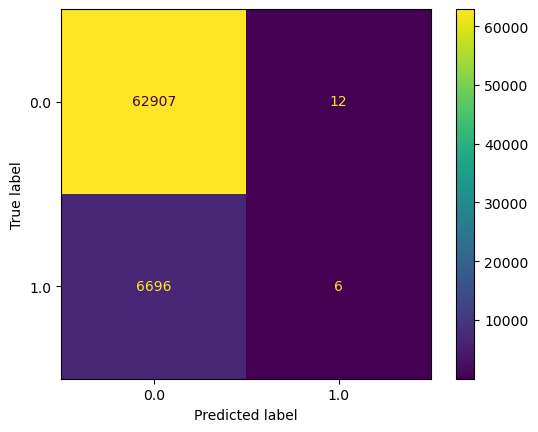

In [22]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xgb_model1,test_X,test_y)

In [26]:
from sklearn.metrics import classification_report
metrics=classification_report(test_y, y_predicted)

In [27]:
print(metrics)

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     62919
         1.0       0.33      0.00      0.00      6702

    accuracy                           0.90     69621
   macro avg       0.62      0.50      0.48     69621
weighted avg       0.85      0.90      0.86     69621



In [42]:
#combining graohs on previous graphs
from sklearn.metrics import roc_curve, auc
plt1 = plt.imread("../figures/testing_ROC.png")


a, b, _ab = roc_curve(test_y, y_score)



roc_auc = auc(a, b)




plt.plot(
    a,
    b,
    color="greem",
    lw=2,
    label="ROC curve (area = %0.2f) XGBoost" % roc_auc,
)
xy=[0, 1]
plt.plot(xy, xy, color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title("ROC combined ")
plt.legend(loc="lower right")

#plt.savefig('./figures/testing_ROC.png')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'imread'

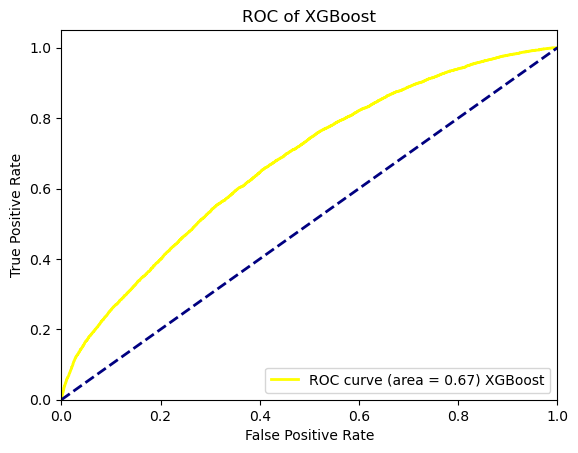

In [45]:
#y_valid_pred = model_xgboost.predict_proba(X_valid)[:,1]
a, b, _ = roc_curve(test_y, y_score)
roc_auc_d = auc(a, b)
plt.figure()
plt.plot(
    a,
    b,
    color="yellow",
    lw=2,
    label="ROC curve (area = %0.2f) XGBoost" % roc_auc_d,
)
xy=[0, 1]
plt.plot(xy, xy, color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC of XGBoost")
plt.legend(loc="lower right")

plt.savefig('../figures/XGBoost_test.png')
comet_exp_obj.log_figure(figure_name="ROC of XGBoost test", 
                             figure=plt, overwrite=False, step=None)
plt.show()

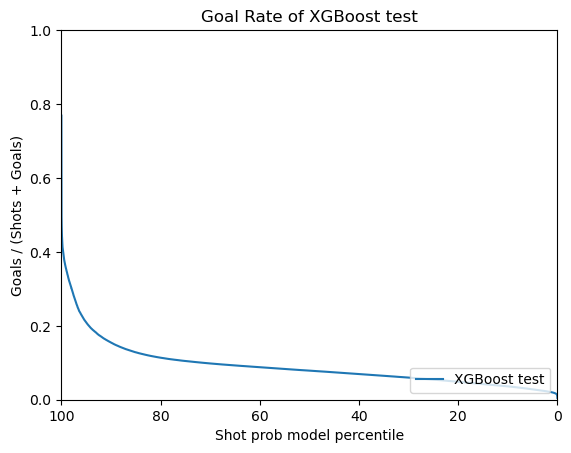

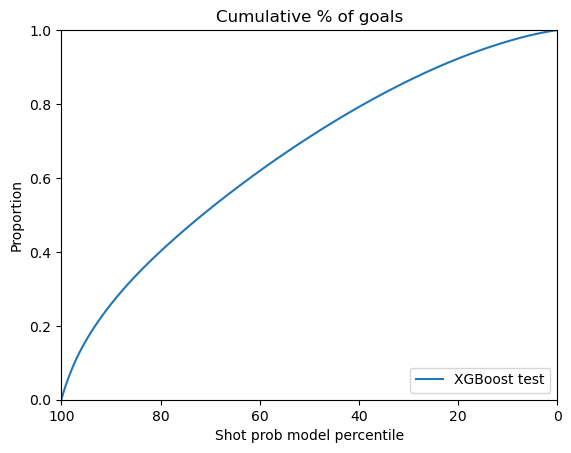

In [46]:
#model percentile
iu =y_score
n = len(iu)
x_axis = np.arange(n)[::-1]*(100/n)
#print(x_axis)

iu_y = iu[::-1]
iu_y[::-1].sort()
# print(sum(lr_probs_y))
#print(lr_probs_y)
iu_y_sum = np.cumsum(iu_y)


plt.figure()
plt.plot(
    x_axis,
    iu_y,
    label = 'XGBoost test'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Goals / (Shots + Goals)")
plt.title("Goal Rate of XGBoost test")
plt.legend(loc="lower right")
plt.savefig('../figures/XGBoost_test1.png')
comet_exp_obj.log_figure(figure_name="Goal Rate of XGBoost test", 
                             figure=plt, overwrite=False, step=None)
plt.show()

#cumulative plot
plt.figure()
plt.plot(
    x_axis,
    iu_y_sum/sum(iu_y),
    label = 'XGBoost test'
)
plt.xlim([100, 0])
plt.ylim([0.0, 1.0])
plt.xlabel("Shot prob model percentile")
plt.ylabel("Proportion")
plt.title("Cumulative % of goals")
plt.legend(loc="lower right")
plt.savefig('../figures/XGBoost_test2.png')
comet_exp_obj.log_figure(figure_name="Cumulative % of goals of xgboost test", 
                             figure=plt, overwrite=False, step=None)
plt.show()

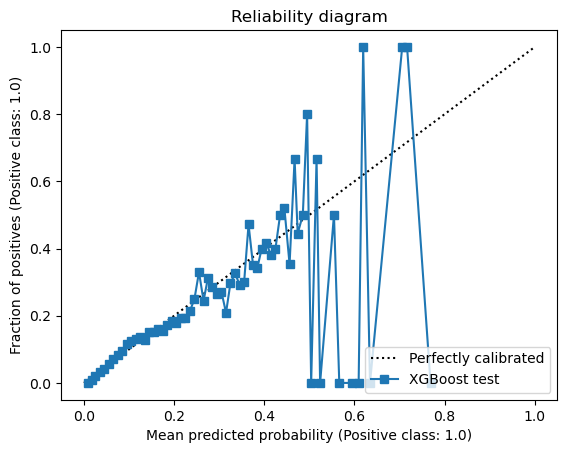

In [47]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_estimator(xgb_model1, test_X, test_y, name='XGBoost test', n_bins = 100)
plt.title("Reliability diagram")
plt.savefig('../figures/XGBoost_test3.png')
comet_exp_obj.log_figure(figure_name="Reliability diagram for xgboost test", 
                             figure=plt, overwrite=False, step=None)
plt.show()